In [1]:
import multiprocessing as mp
import numpy as np
import os
import torch as th
import torchvision.transforms as T
import warnings

from captum.attr import (
    DeepLift,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    KernelShap,
    Lime,
    NoiseTunnel,
    Saliency,
)
from captum.attr import visualization as viz
from captum.metrics import sensitivity_max
from captum._utils.typing import (
    TargetType,
    TensorOrTupleOfTensorsGeneric,
)

from argparse import ArgumentParser
from matplotlib.colors import LinearSegmentedColormap
from pytorch_lightning import Trainer, seed_everything
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision.models import resnet18
from typing import Any, List

from tint.attr import (
    AugmentedOcclusion,
    DynaMask,
    ExtremalMask,
    GeodesicIntegratedGradients,
    Occlusion,
)
from tint.attr.models import ExtremalMaskNet, MaskNet
from tint.metrics import (
    accuracy,
    comprehensiveness,
    cross_entropy,
    lipschitz_max,
    log_odds,
    sufficiency,
)
from tint.models import CNN
from tint.utils import get_progress_bars

warnings.filterwarnings("ignore")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
device = "cpu"

# Get data transform
transform = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
target_transform = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Lambda(lambda x: (x * 255).long()),
    ]
)

# Load test data
voc = VOCSegmentation(
    root="../tint/data/voc",
    image_set="val",
    transform=transform,
    target_transform=target_transform,
    download=True,
)
voc_loader = DataLoader(voc, batch_size=1, shuffle=True)

# Load model
resnet = resnet18(pretrained=True)

# Switch to eval
resnet.eval()

# Set model to device
resnet.to(device)

# Get data as tensors
# we only load 100 images
x_test = list()
seg_test = list()
i = 0
for data, seg in voc_loader:
    if i == 10:
        break

    seg_ids = seg.unique()
    if len(seg_ids) <= 1:
        continue

    seg_ = seg.clone()
    for j, seg_id in enumerate(seg_ids):
        seg_[seg_ == seg_id] = j

    x_test.append(data)
    seg_test.append(seg_)
    i += 1

x_test = th.cat(x_test).to(device)
seg_test = th.cat(seg_test).to(device)

# Target is the model prediction
y_test = resnet(x_test).argmax(-1).to(device)

# Create dict of attributions, explainers, sensitivity max
# and lipschitz max
attr = dict()

Using downloaded and verified file: ../tint/data/voc/VOCtrainval_11-May-2012.tar
Extracting ../tint/data/voc/VOCtrainval_11-May-2012.tar to ../tint/data/voc


In [7]:
explainer = IntegratedGradients(resnet)
attr_ig = explainer.attribute(
    x_test,
    target=y_test,
    internal_batch_size=200,
)

In [13]:
_attr = list()

for i, (x, y) in get_progress_bars()(
        enumerate(zip(x_test, y_test)),
        total=len(x_test),
        desc=f"{GeodesicIntegratedGradients.get_name()} attribution",
    ):
    rand = th.rand((50,) + x.shape).sort(dim=0).values.to(device)
    x_aug = x.unsqueeze(0) * rand
    explainer = GeodesicIntegratedGradients(
        resnet, data=x_aug, n_neighbors=5
    )

    _attr.append(
        explainer.attribute(
            x.unsqueeze(0),
            target=y.item(),
            internal_batch_size=10,
        )
    )

attr_gig = th.cat(_attr)

Geodesic Integrated Gradients attribution:   0%|          | 0/10 [00:00<?, ?it/s]

In [121]:
i = 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


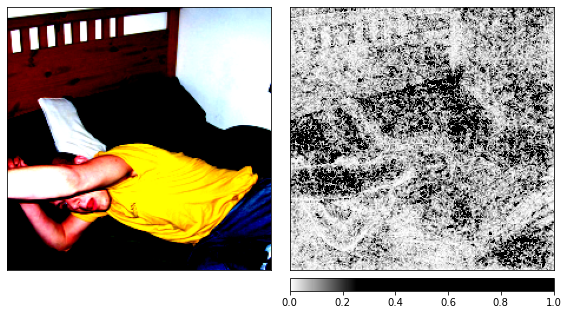

In [122]:
out = viz.visualize_image_attr_multiple(
    np.transpose(attr_ig[i].squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_test[i].squeeze().cpu().detach().numpy(), (1,2,0)),
    ["original_image", "heat_map"],
    ["all", "absolute_value"],
    cmap=default_cmap,
    show_colorbar=True,
)

In [123]:
out[0].savefig("ig.pdf")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


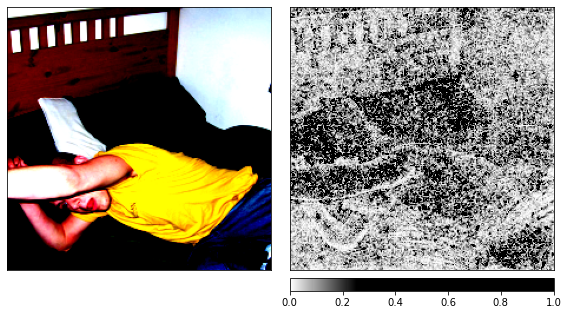

In [124]:
out = viz.visualize_image_attr_multiple(
    np.transpose(attr_gig[i].squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_test[i].squeeze().cpu().detach().numpy(), (1,2,0)),
    ["original_image", "heat_map"],
    ["all", "absolute_value"],
    cmap=default_cmap,
    show_colorbar=True,
)

In [125]:
out[0].savefig("gig.pdf")

In [54]:
import matplotlib.pyplot as plt
import json

with open("../tint/data/voc/imagenet_class_index.json", "r") as fp:
    labels_dict = json.load(fp)

In [42]:
resnet(x_test).argmax(-1)[7]

tensor(518)

In [44]:
labels_dict

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

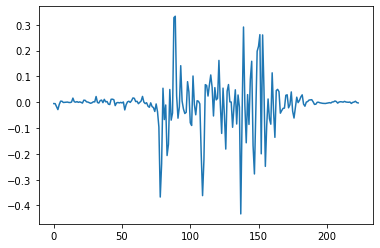

In [32]:
import matplotlib.pyplot as plt
plt.plot(attr[i].sum(0)[120].detach())

In [1]:
import numpy as np
import torch as th

from os import path


import matplotlib.pyplot as plt

from pytorch_lightning import Trainer
from tqdm.notebook import tqdm

#scikit-learn related imports
import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import (
    IntegratedGradients, 
    DeepLift, 
    GradientShap, 
    NoiseTunnel, 
    FeatureAblation, 
    InputXGradient, 
    Lime,
    KernelShap,
    Saliency,
)

from tint.attr import GeodesicIntegratedGradients
from tint.models import Net, MLP

In [2]:
housing = load_boston()
X, y = housing["data"], housing["target"]

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include

In [3]:
feature_names = housing.feature_names

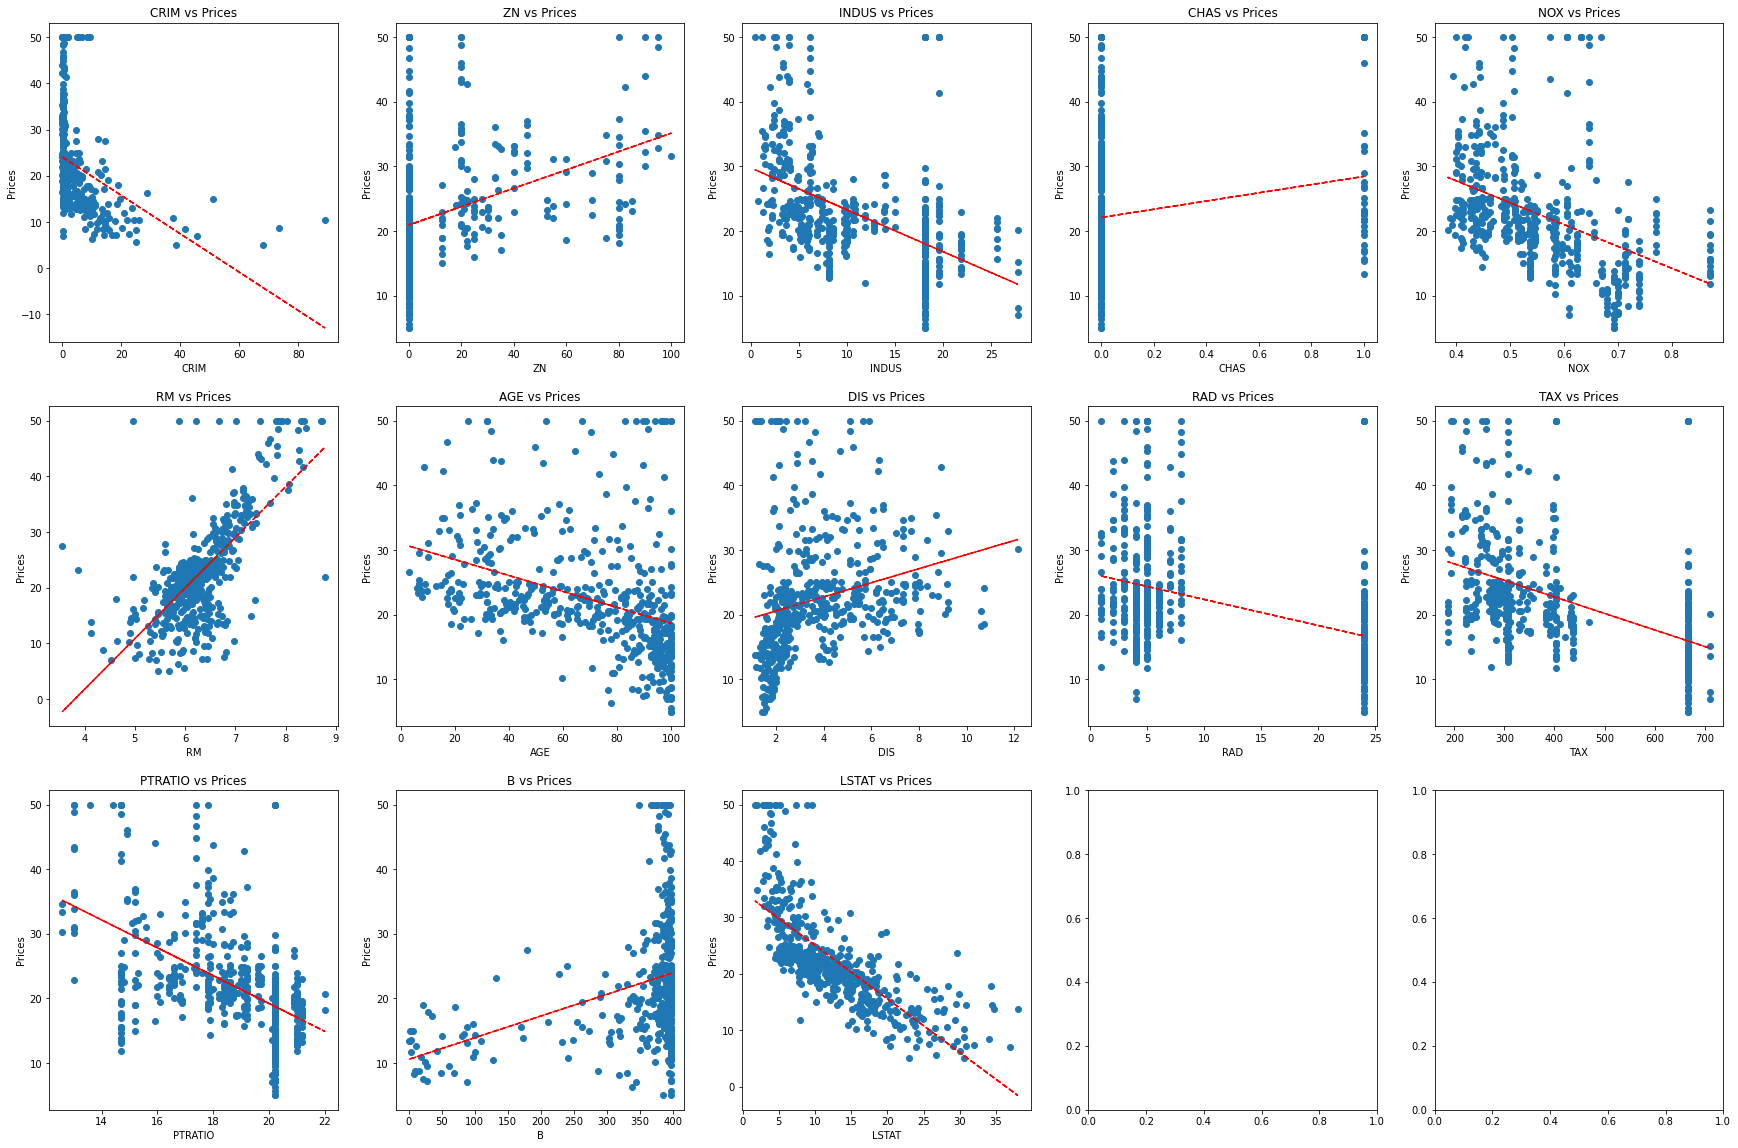

In [4]:
fig, axs = plt.subplots(nrows = 3, ncols=5, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Prices')
    ax.set_xlabel(col)
    ax.set_ylabel('Prices')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

In [7]:
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [51]:
regressor = Net(MLP([13, 5, 1]), lr=0.0001, loss="mse")

In [52]:
trainer = Trainer(max_epochs=200)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1788: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [53]:
trainer.fit(regressor, train_dataloaders=train_iter)

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type    | Params
----------------------------------
0 | net   | MLP     | 76    
1 | _loss | MSELoss | 0     
----------------------------------
76        Trainable params
0         Non-trainable params
76        Total params
0.000     Total estimated model params size (MB)
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/joseph.enguehard/opt/min

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [54]:
regressor.eval()
outputs = regressor(X_test)

mse = ((outputs - y_test) ** 2).mean()
print("mse: ", mse)

mse:  tensor(47.7713, grad_fn=<MeanBackward0>)


In [79]:
ig = IntegratedGradients(regressor)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(regressor)
gs = GradientShap(regressor)
fa = FeatureAblation(regressor)
ixg = InputXGradient(regressor)
sa = Saliency(regressor)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_test * 0.)
fa_attr_test = fa.attribute(X_test)
ixg_attr_test = ixg.attribute(X_test)
sa_attr_test = sa.attribute(X_test, abs=False)

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


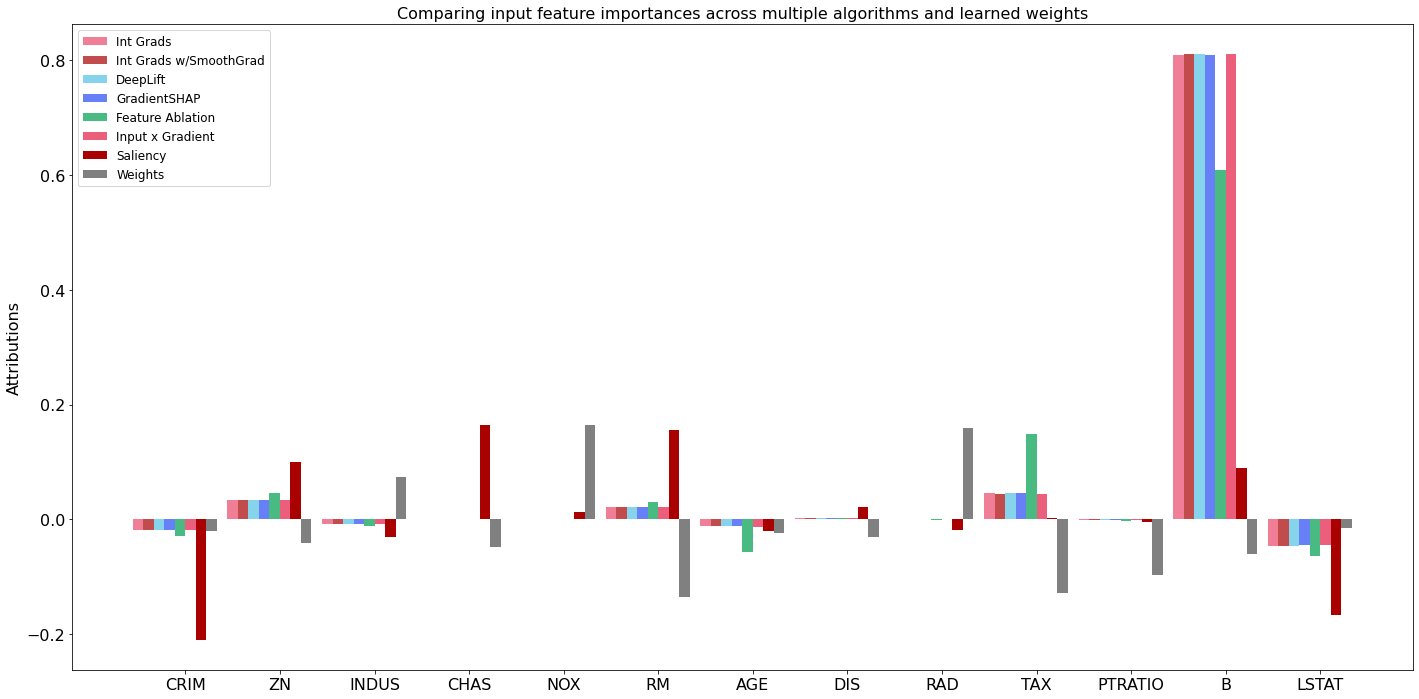

In [82]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

sa_attr_test_sum = sa_attr_test.detach().numpy().sum(0)
sa_attr_test_norm_sum = sa_attr_test_sum / np.linalg.norm(sa_attr_test_sum, ord=1)

lin_weight = regressor.net.mlp[0].weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.111
legends = [
    'Int Grads', 
    'Int Grads w/SmoothGrad',
    'DeepLift', 
    'GradientSHAP', 
    'Feature Ablation', 
    "Input x Gradient",
    "Saliency",
    'Weights',
]

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, ixg_attr_test_norm_sum, width, align='center', alpha=1.0, color='#eb5e7c')
ax.bar(x_axis_data + 6 * width, sa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#A90000')
ax.bar(x_axis_data + 7 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=0)
plt.show()

In [94]:
regressor(X_test[0].unsqueeze(0))

tensor([[23.9458]], grad_fn=<AddmmBackward0>)

In [95]:
weight_1 = regressor.net.mlp[0].weight
weight_2 = regressor.net.mlp[2].weight

bias_1 = regressor.net.mlp[0].bias
bias_2 = regressor.net.mlp[2].bias

In [98]:
(X_test[0].unsqueeze(0) @ weight_1.t() + bias_1).clamp(min=0) @ weight_2.t() + bias_2

tensor([[23.9458]], grad_fn=<AddBackward0>)

In [135]:
sa_attr_test[:, 1]

tensor([ 0.0803,  0.0803,  0.0293,  0.0803,  0.0293,  0.0803,  0.0803,  0.0803,
         0.0293,  0.0803,  0.0803,  0.0803, -0.0510,  0.0803,  0.0803,  0.0803,
         0.0803,  0.0293,  0.0803,  0.0293,  0.0803,  0.0803,  0.0803,  0.0803,
         0.0293,  0.0293,  0.0803, -0.0510,  0.0803,  0.0803,  0.0803,  0.0803,
         0.0803,  0.0293,  0.0293,  0.0293,  0.0803,  0.0803,  0.0803,  0.0803,
         0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0293,  0.0803,  0.0803,
         0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,
         0.0293,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,
         0.0803,  0.0803,  0.0293,  0.0803,  0.0803, -0.0510,  0.0803,  0.0803,
         0.0293,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0803,  0.0293,
         0.0803,  0.0293,  0.0803,  0.0293,  0.0803,  0.0803,  0.0293,  0.0803,
         0.0803,  0.0803,  0.0803, -0.0510,  0.0803,  0.0803,  0.0293,  0.0803,
         0.0293, -0.0510, -0.0510, -0.05

In [137]:
weight_2 @ weight_1

tensor([[-0.2173, -0.0213,  0.0310,  0.1408,  0.0434,  0.0125,  0.0003, -0.0121,
          0.1192, -0.0606, -0.0797, -0.0315, -0.0889]], grad_fn=<MmBackward0>)

In [133]:
weight_1.t()

tensor([[-0.0321, -0.4717, -0.0679, -0.0104, -0.2755],
        [-0.0637,  0.3212,  0.0640,  0.2417, -0.1725],
        [ 0.1157, -0.0693,  0.2079,  0.0395, -0.0427],
        [-0.0755,  0.3443,  0.2059,  0.1479,  0.2935],
        [ 0.2561,  0.0881, -0.1818,  0.1797, -0.1626],
        [-0.2121,  0.3441, -0.1942,  0.2538,  0.2100],
        [-0.0382, -0.1302, -0.2219,  0.0106,  0.2326],
        [-0.0473,  0.0735,  0.0956,  0.0193, -0.0557],
        [ 0.2497, -0.0911,  0.0209,  0.0074,  0.1253],
        [-0.2013, -0.0091, -0.1748, -0.2297,  0.0414],
        [-0.1524, -0.0422, -0.1036,  0.2127,  0.0981],
        [-0.0945,  0.2822, -0.2172,  0.0395, -0.1339],
        [-0.0235, -0.4578,  0.0987, -0.1072,  0.0473]], grad_fn=<TBackward0>)

In [236]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn.functional as F

plt.rcParams["figure.figsize"] = (15, 4)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

In [237]:
def sigmoid_prime(a = 1., x=20., n=1000):
    return list((
        a * F.sigmoid(th.linspace(-x, x, n)) * 
        (1. - F.sigmoid(th.linspace(-x, x, n)))
    ).numpy())

In [238]:
out = sigmoid_prime(x=15.) * 4 + sigmoid_prime(a=1.5, x=15.)

gaussian = (
    sigmoid_prime(x=15.) * 2 + 
    sigmoid_prime(a=.5, x=15.) + 
    sigmoid_prime(x=15.) + 
    sigmoid_prime(a=1.5, x=15.)
)

_out = np.array(copy.deepcopy(out))
_out[2400:2600] = np.array(out).mean()
_out = list(_out)

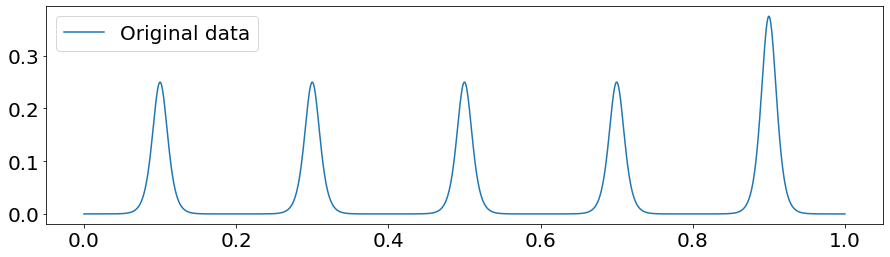

In [247]:
plt.plot(np.linspace(0, 1, len(out)), out, label="Original data")
plt.legend(fontsize=20, loc="upper left")
plt.savefig("func.pdf")

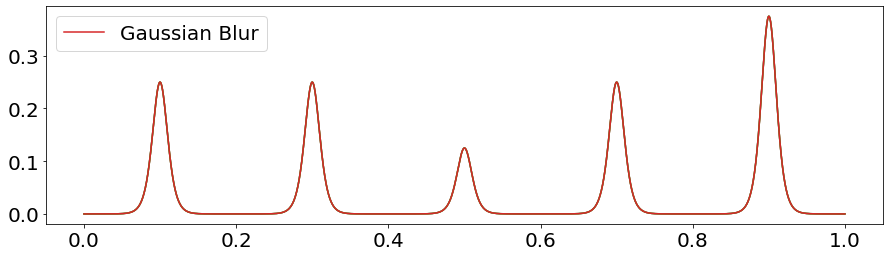

In [244]:
plt.plot(np.linspace(0, 1, len(gaussian)), gaussian)
plt.plot(np.linspace(0, 1, len(gaussian)), gaussian)
plt.plot(np.linspace(0, 1, len(gaussian)), gaussian)
plt.plot(np.linspace(0, 1, len(gaussian)), gaussian, label="Gaussian Blur")
plt.legend(fontsize=20, loc="upper left")
plt.savefig("gaussian.pdf")

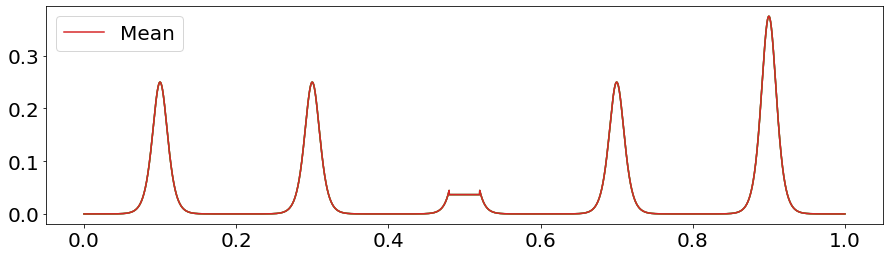

In [245]:
plt.plot(np.linspace(0, 1, len(_out)), _out)
plt.plot(np.linspace(0, 1, len(_out)), _out)
plt.plot(np.linspace(0, 1, len(_out)), _out)
plt.plot(np.linspace(0, 1, len(_out)), _out, label="Mean")
plt.legend(fontsize=20, loc="upper left")
plt.savefig("mean.pdf")

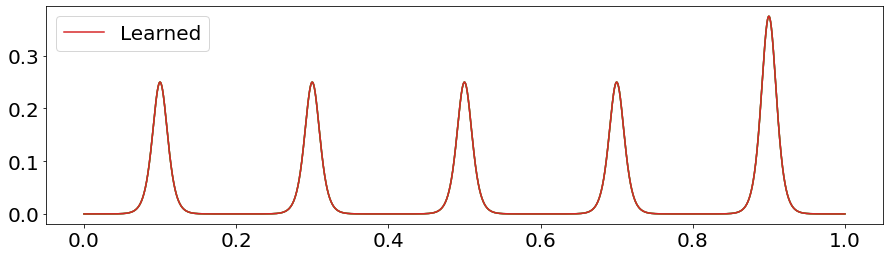

In [246]:
plt.plot(np.linspace(0, 1, len(out)), out)
plt.plot(np.linspace(0, 1, len(out)), out)
plt.plot(np.linspace(0, 1, len(out)), out)
plt.plot(np.linspace(0, 1, len(out)), out, label="Learned")
plt.legend(fontsize=20, loc="upper left")
plt.savefig("learned.pdf")

In [473]:
import matplotlib.pyplot as plt
import pandas as pd

In [528]:
df = pd.read_csv("../experiments/mimic3/mortality/extremal_mask_params.csv")

In [523]:
df = df[df.Baseline == "Average"]

In [524]:
areas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
explainers = ["deep_lift", "dyna_mask", "occlusion", "extremal_mask"]
metric = "Sufficiency"

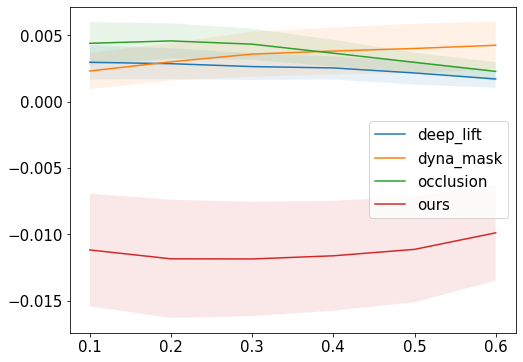

In [527]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

for explainer in explainers:
    _df = df[df.Explainer == explainer]
    plt.plot(_df.groupby("Topk")[metric].mean(), label="ours" if explainer=="extremal_mask" else explainer)
    plt.fill_between(
        areas,
        _df.groupby("Topk")[metric].mean() - _df.groupby("Topk")[metric].std(),
        _df.groupby("Topk")[metric].mean() + _df.groupby("Topk")[metric].std(),
        alpha=0.1,
    )
plt.legend(fontsize=15, loc="right")
plt.savefig("suff_average.pdf")

In [354]:
for name, score in df.groupby("Explainer")["Sufficiency"].std().to_dict().items():
    print(name, f"{score:.3f}")

extremal_mask_bi_gru 0.006
extremal_mask_gru 0.001
extremal_mask_none 0.002


In [570]:
df = pd.read_csv("../experiments/mimic3/mortality/extremal_mask_params.csv")

In [571]:
df = df[df.Baseline == "Zeros"]

In [572]:
areas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
explainers = ["extremal_mask_none", "extremal_mask_gru", "extremal_mask_bi_gru"]
metric = "Accuracy"
name_dict = {
    "extremal_mask_none": "Zeros",
    "extremal_mask_gru": "GRU",
    "extremal_mask_bi_gru": "BiGRU"
}

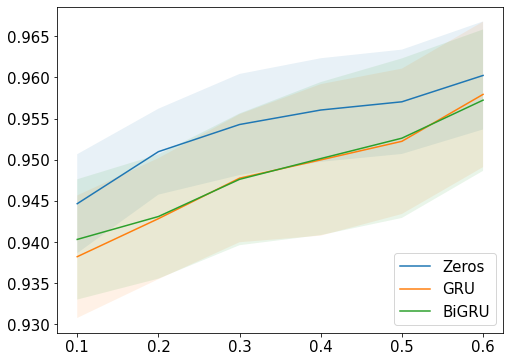

In [574]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

for explainer in explainers:
    _df = df[df.Explainer == explainer]
    plt.plot(_df.groupby("Topk")[metric].mean(), label=name_dict[explainer])
    plt.fill_between(
        areas,
        _df.groupby("Topk")[metric].mean() - _df.groupby("Topk")[metric].std(),
        _df.groupby("Topk")[metric].mean() + _df.groupby("Topk")[metric].std(),
        alpha=0.1,
    )
plt.legend(fontsize=15, loc="lower right")
plt.savefig("acc_zeros_abl.pdf")